In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import normal
from numpy.random import uniform
from numpy.random import exponential
from numpy.random import noncentral_chisquare

# Generate a Markov process given transition probability

* Know:

    * $t$: current time point
    
    * $b$: current state
    
    * $t+\Delta t$: next time point 
    
    * $X_{t+\Delta t}| X_t = b \sim f_{t,t+\Delta t, b}$
    
* Problem: How to find $X_{t+\Delta}$?

* **Solution**
    1. Generate $U \sim \text{Uniform}[0,1]$.
    
    2. Compute the inverse of CDF of $X_{t+\Delta t}| X_t = b$ based on its density ($F^{-1}$)
    
    3. Let $\hat{X}_{t+\Delta t} = F^{-1}(U)$

In [2]:
'''
class MarkovProcess
    Used to generate a real-value Markov Process given transition probability

Method:
.get_simulation(num_trails = 1000, start_time = 0, end_time = 1)
    Input: 
        num_trails - a positive integer. number of points
        start_time - a positive real number.
        end_time - a positive real number.
    Output:
        np.array with dim = (num_trails, 2). Each row represent a point (t, B_t).
'''
class MarkovProcess:
    def __init__(self, trans,  initial_state=0):
        self.initial_state = initial_state
        self.trans = trans
        self.simulation = 0
        
    def get_simulation(self, num_trails=1000, start_time=0.0, end_time=1.0):
        current_state = self.initial_state
        current_time = start_time
        increment = (end_time-start_time)/num_trails
        time_list = [current_time]
        state_list = [current_state]
        
        get_new_state = self.trans
        
        for i in range(num_trails): 
            current_state = get_new_state( current_time, current_state, current_time + increment )
            current_time += increment 
            time_list.append(current_time)
            state_list.append(current_state)
        
        self.simulation = [ time_list, state_list ]
        return self.simulation
    
    def figure(self):
        if self.simulation == 0:
            output = self.get_simulation()
        else:
            output = self.simulation
        plt.plot(output[0],output[1])

In [3]:
class BrownianMotion(MarkovProcess):
    def __init__(self, initial_state=0):
        def BM_trans( current_time, current_state, next_time ):
            return normal()*np.sqrt( next_time - current_time ) + current_state
        self.initial_state = initial_state
        self.trans = BM_trans
        self.simulation = 0

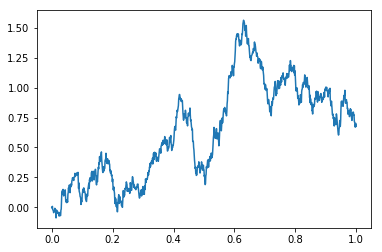

In [4]:
MP = BrownianMotion()
MP.figure()

# Generate CIR diffusion

We want to generate $r_t$ which is defined as
$$d r_t = a(b-r_t) dt + \sigma \sqrt{r_t} dW_t.$$

And we know that 
$$r_{t+\Delta t}|r_t= \chi^2( \frac{4ab}{\sigma^2}, 2c r_t e^{-a \Delta t} )$$
where $c = \frac{2a}{(1 - e^{-a \Delta t})\sigma^2}$.

In [7]:
class CIR(MarkovProcess):
    def __init__(self, a=1.0, b=1.2, sigma=0.2, initial_state=0):
        def CIR_trans( ctime, cstate, ntime ):
            dt = ntime - ctime
            r_t = cstate
            c = 2*a/(  (1 - np.exp(-a*dt))*(sigma**2) )
            degree_of_freedom = 4*a*b/sigma**2
            non_centrality = 2 * c * r_t * np.exp(-a * dt)  
            return noncentral_chisquare(degree_of_freedom, non_centrality)/(2*c)
        
        self.initial_state = initial_state
        self.trans = CIR_trans
        self.simulation = 0

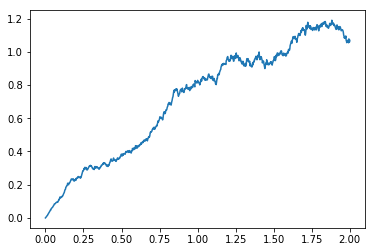

In [44]:
MP = CIR(initial_state=0)
MP.get_simulation(end_time=2)
MP.figure()

# Generate a Poisson process

In [48]:
class Poission(MarkovProcess):
    def __init__(self, beta = 1.0, initial_state=0):
        #NOTE: beta:= 1/ lemabda
        def Poission_trans( current_time, current_state, next_time ):
            dt = next_time - current_time
            next_jump_time = exponential(beta)
            if next_jump_time<= dt:
                return current_state+1
            else:
                return current_state
        self.initial_state = initial_state
        self.trans = Poission_trans
        self.simulation = 0

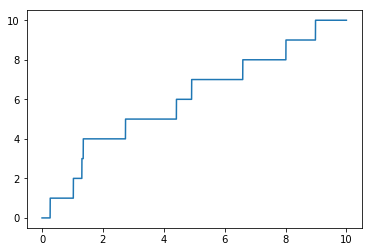

In [49]:
MP = Poission()
MP.get_simulation( num_trails=10000, start_time=0.0, end_time=10)
MP.figure()

# Generate other counting process with time change

In [54]:
class TimeChangedProcess(MarkovProcess):
    def get_simulation(self, time_change, num_trails=1000, start_time=0.0, end_time=1.0):
        current_state = self.initial_state
        current_time = start_time
        increment = (end_time-start_time)/num_trails
        time_list = [current_time]
        state_list = [current_state]
        
        get_new_state = self.trans
        
        for i in range(num_trails): 
            current_state = get_new_state( time_change(current_time), current_state, time_change(current_time + increment) )
            current_time += increment 
            time_list.append(current_time)
            state_list.append(current_state)
        
        self.simulation = [ time_list, state_list ]
        return self.simulation
    
    def figure(self):
        if self.simulation == 0:
            def time_change(t):
                return t
            output = self.get_simulation(time_change)
        else:
            output = self.simulation
        plt.plot(output[0],output[1])